In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torchmetrics.classification.calibration_error import MulticlassCalibrationError
from torchmetrics.functional.classification.calibration_error import _binning_bucketize
import torch

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from expected_cost.ec import average_cost, CostMatrix

from hm4.labelling import CLASS_NAMES
import hm4.labelling as labelling
from hm4.expected_cost import COST_ARRAY
from crism_ml.lab import relabel, ALIASES_TRAIN

In [ ]:
# Filepath for the holdout data preprocessed as by Dhoundiyal et al. (2025) and aggregated.
# See scripts/dhoundiyal_benchmark for the preprocessing scripts.
HOLDOUT_DATA_PATH = #
RF_MODEL_WEIGHTS_PATH = # Path to the saved Random Forest model .pkl file. Train the model in the retrain_platt_data.ipynb notebook.

In [ ]:
holdout_data = pd.read_json(HOLDOUT_DATA_PATH)

In [3]:
x_holdout = holdout_data.iloc[:, :-3].to_numpy()
y_holdout = holdout_data.iloc[:, -3].to_numpy()

In [ ]:
with open(RF_MODEL_WEIGHTS_PATH, 'rb') as f:
    rf_model = pickle.load(f)

In [5]:
y_pred = rf_model.predict(x_holdout)

In [6]:
cost_matrix = CostMatrix(COST_ARRAY)
priors = np.full(38, 1 / 38) # uniform priors

In [7]:
print(f"Accuracy: {accuracy_score(y_holdout, y_pred)}")

Accuracy: 0.5413363533408834


In [8]:
# Calculate performance metrics

true_unique_classes = np.unique(y_holdout)
predicted_unique_classes = np.unique(y_pred)
classes_to_calculate_f1 = np.unique(np.concatenate((true_unique_classes, predicted_unique_classes)))
string_labels = np.array([CLASS_NAMES[int(obs_class)] for obs_class in classes_to_calculate_f1])

report = classification_report(y_holdout, y_pred, output_dict=True)
expected_cost = average_cost(y_holdout, y_pred, cost_matrix, priors)


/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [33]:
print(f"Accuracy: {report['accuracy']}")
print(f"Macro F1: {report['macro avg']['f1-score']}")
print(f"Weighted F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {report['macro avg']['precision']}")
print(f"Recall: {report['macro avg']['recall']}")
print(f"Expected Cost: {expected_cost}")

Accuracy: 0.5413363533408834
Macro F1: 0.1408515192374472
Weighted F1: 0.6122384327657757
Precision: 0.17432978125698656
Recall: 0.14485759147797653
Expected Cost: 0.11908058376622653


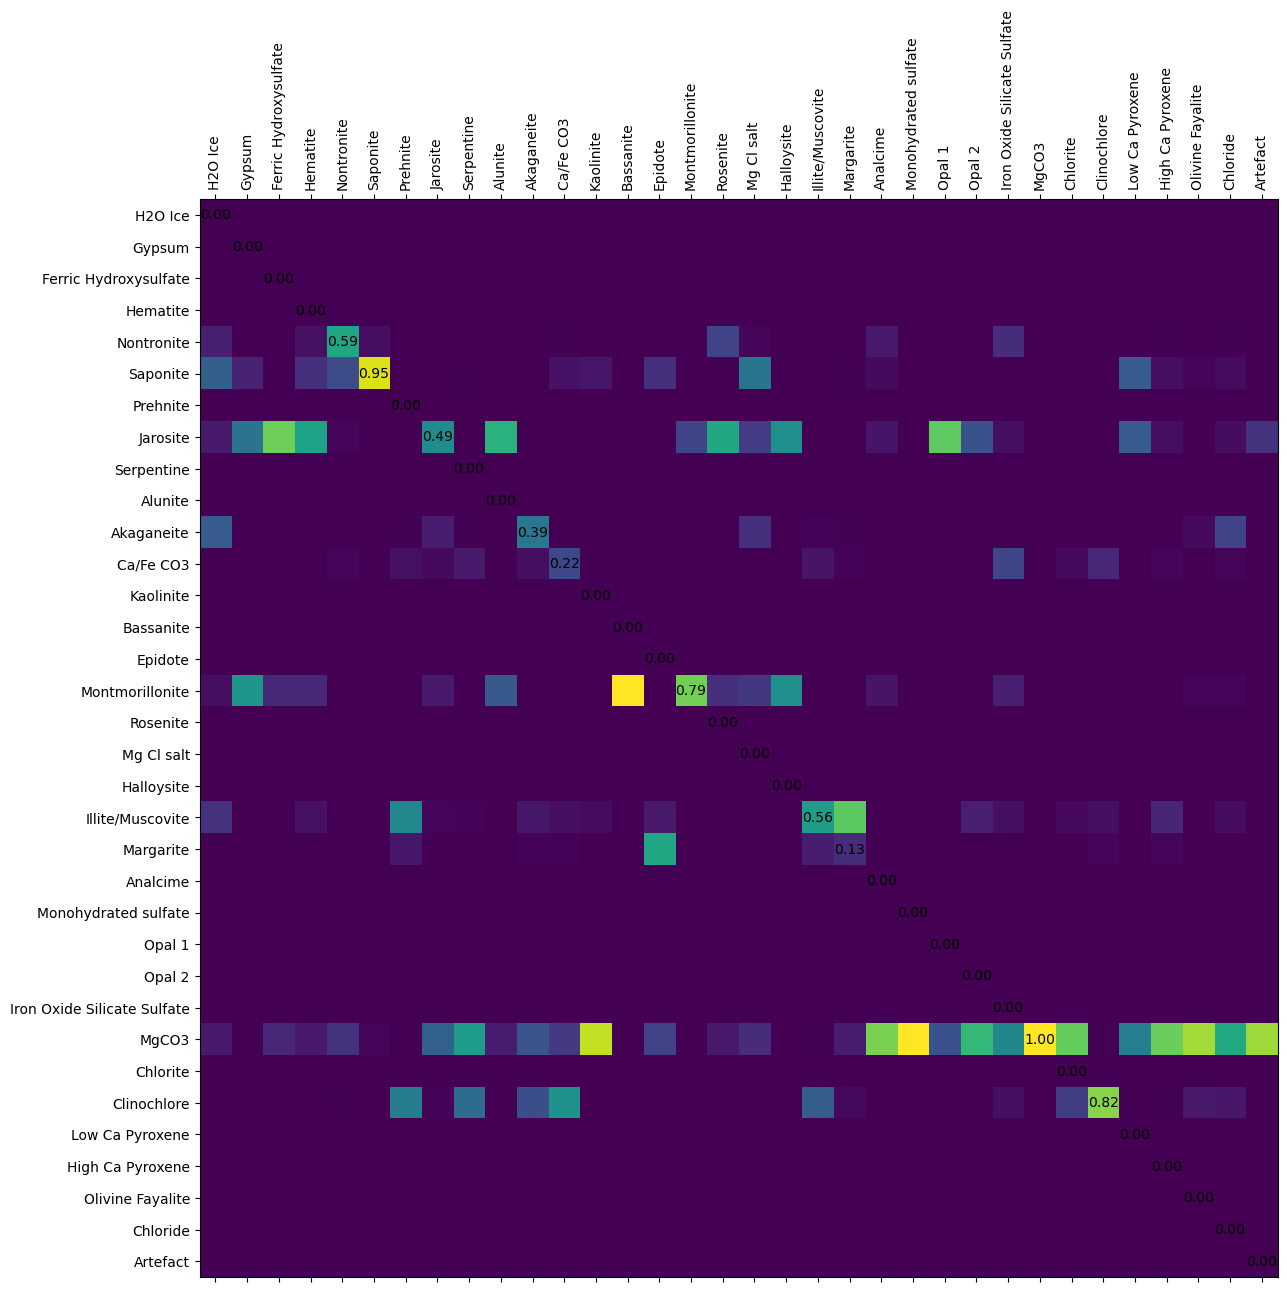

In [10]:
# Plot the confusion matrix
cm = confusion_matrix(y_holdout, y_pred, normalize="pred")
fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(cm, cmap='viridis')
# add class labels to x and y axes
ax.set_xticks(range(len(string_labels)))
ax.set_yticks(range(len(string_labels)))
ax.set_xticklabels(string_labels, rotation=90)
ax.set_yticklabels(string_labels)
# plot the cm values in the boxes, rounded to 2dp
for i in range(len(string_labels)):
    for j in range(len(string_labels)):
        if i != j:
            continue
        ax.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')


In [12]:
# first need to map the labels back to the FULL_NAMES as listed in crism_ml.lab
y_true_relabelled = labelling.change_pixel_label(y_holdout, in_val=21, out_val=38)
y_pred_relabelled = labelling.change_pixel_label(y_pred, in_val=21, out_val=38)

y_true_relabelled = labelling.make_array_zero_indexed(y_true_relabelled, forwards=False, force=True)
y_pred_relabelled = labelling.make_array_zero_indexed(y_pred_relabelled, forwards=False, force=True)


In [13]:
y_true_relabelled = relabel(y_true_relabelled, ALIASES_TRAIN)
y_pred_relabelled = relabel(y_pred_relabelled, ALIASES_TRAIN)

In [14]:
# for expected cost the labels need to be zero indexed, otherwise the highest class number will be out of range
y_true_relabelled_zero = labelling.make_array_zero_indexed(y_true_relabelled, forwards=True)
y_pred_relabelled_zero = labelling.make_array_zero_indexed(y_pred_relabelled, forwards=True)

In [15]:
super_class_report = classification_report(y_pred_relabelled, y_true_relabelled, output_dict=True)
super_class_expected_cost = average_cost(y_true_relabelled_zero, y_pred_relabelled_zero, cost_matrix, priors)
print(f"Super class accuracy: {super_class_report['accuracy']}")
print(f"Super class macro F1: {super_class_report['macro avg']['f1-score']}")
print(f"Super class weighted F1: {super_class_report['weighted avg']['f1-score']}")
print(f"Super class precision: {super_class_report['macro avg']['precision']}")
print(f"Super class recall: {super_class_report['macro avg']['recall']}")
print(f"Super class expected cost: {super_class_expected_cost}")

Super class accuracy: 0.681766704416761
Super class macro F1: 0.17630154098513184
Super class weighted F1: 0.6054935623494749
Super class precision: 0.16462880770825145
Super class recall: 0.20262803954582617
Super class expected cost: 0.11018642011497662


/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Confidence Calibration Assessment

In [16]:
pred_probs = rf_model.predict_proba(x_holdout)

In [23]:
accuracies = y_pred == y_holdout
accuracies = torch.tensor(accuracies)
bin_bounds = torch.linspace(0, 1, 11) # ten bins
confidence = torch.tensor(pred_probs.max(axis=1))
acc_bin, conf_bin, prop_bin = _binning_bucketize(confidence, accuracies, bin_bounds) # bucketize the probs/confs, the accuracies, and the proportion of data in each bin


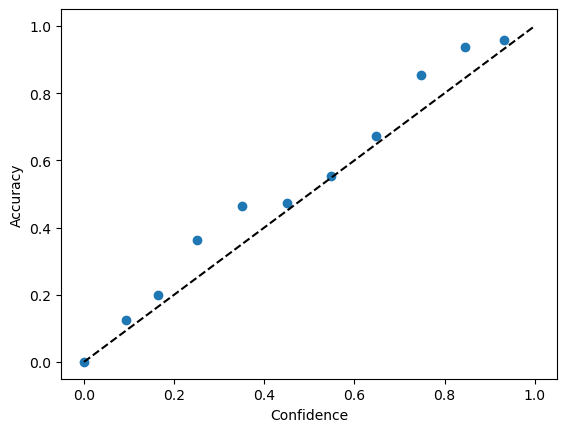

In [24]:
fig, ax = plt.subplots()
ax.scatter(conf_bin, acc_bin)
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
# add a diagonal line for reference
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

In [ ]:
conf_bin

tensor([0.0888, 0.1656, 0.2524, 0.3514, 0.4481, 0.5487, 0.6486, 0.7475, 0.8249,
        0.0000, 0.0000], dtype=torch.float64)

In [26]:
print(f"Mean confidnece: {confidence.mean()}, minimum confidence {confidence.min()}, maximum confidence {confidence.max()}")

Mean confidnece: 0.4777380825985547, minimum confidence 0.0869140625, maximum confidence 0.98828125


In [30]:
pred_probs.shape

(18543, 37)

In [ ]:
torch.save(acc_bin, "dhoundiyal_holdout_accuracy_vals.pt")
torch.save(conf_bin, "dhoundiyal_holdout_confidence_vals.pt")
torch.save(pred_probs, "dhoundiual_holdout_pred_probs.pt")

In [32]:
calibration_metric = MulticlassCalibrationError(num_classes=37, n_bins=10)
calibration_metric.update(torch.Tensor(pred_probs), torch.Tensor(y_holdout))
ece = calibration_metric.compute()
print(f"ECE: {ece}")

ECE: 0.24010112881660461
